# Текст задания

Нужно сгенерировать 3 cлучайных нелинейных регрессии. Для обоих частей задания зафиксировать размерности 2-3х линейных слоев, их активации, функцию потери, lr и оптимизатор, кол-во эпох. \\
Первая часть задания: протестировать модель только с батчнормом с 3 разными
размерами батча. \\
Вторая часть: протестировать модель с лучшим размером батча из первой части
* без дропаута и без батчнорма,
* только с батчнормом без дропаута,
* только с дропаутом без батчнорма,
* и с батчнормом и с дропаутом.

Визуализировать результаты. \\
В пару предложений записать выводы.

# Код

## Imports

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

## Датасет

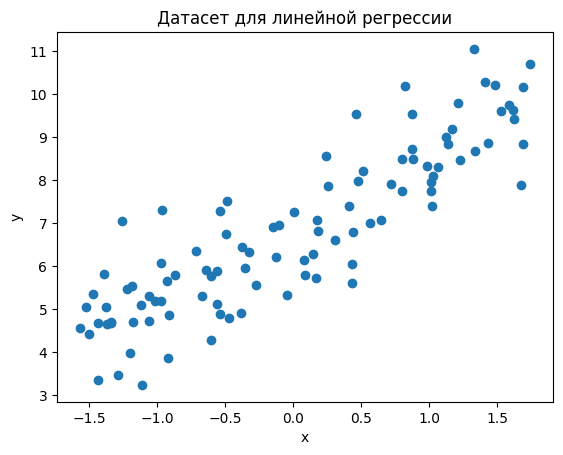

In [133]:
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df = pd.DataFrame({'x': X_scaled.flatten(), 'y': y.flatten()})

plt.scatter(df['x'], df['y'])
plt.title('Датасет для линейной регрессии')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [134]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)

In [135]:
input_size = 1
hidden_size1 = 16
hidden_size2 = 8
output_size = 1
activation = nn.ReLU()
loss_function = nn.MSELoss()
learning_rate = 0.01
optimizer_class = optim.Adam
num_epochs = 100

In [136]:
def create_model(batch_norm=False, dropout=False):
    layers = []
    layers.append(nn.Linear(input_size, hidden_size1))

    if batch_norm:
        layers.append(nn.BatchNorm1d(hidden_size1))

    layers.append(activation)

    if dropout:
        layers.append(nn.Dropout(0.5))

    layers.append(nn.Linear(hidden_size1, hidden_size2))

    if batch_norm:
        layers.append(nn.BatchNorm1d(hidden_size2))

    layers.append(activation)

    if dropout:
        layers.append(nn.Dropout(0.5))

    layers.append(nn.Linear(hidden_size2, output_size))

    return nn.Sequential(*layers)

## Part I

In [137]:
batch_sizes = [16, 32, 64]
results_batch_norm = {}

for batch_size in batch_sizes:
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = create_model(batch_norm=True)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        for x, y in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    results_batch_norm[batch_size] = losses

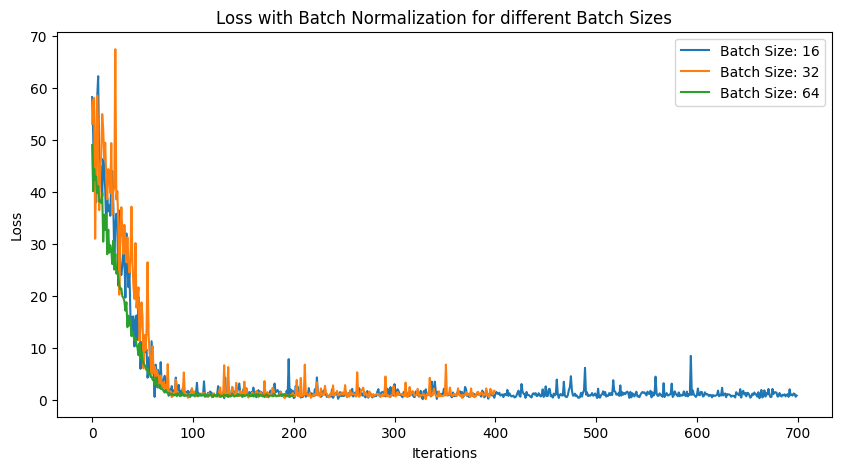

In [138]:
plt.figure(figsize=(10, 5))

for batch_size, losses in results_batch_norm.items():
    plt.plot(losses, label=f'Batch Size: {batch_size}')

plt.title('Loss with Batch Normalization for different Batch Sizes')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Part II

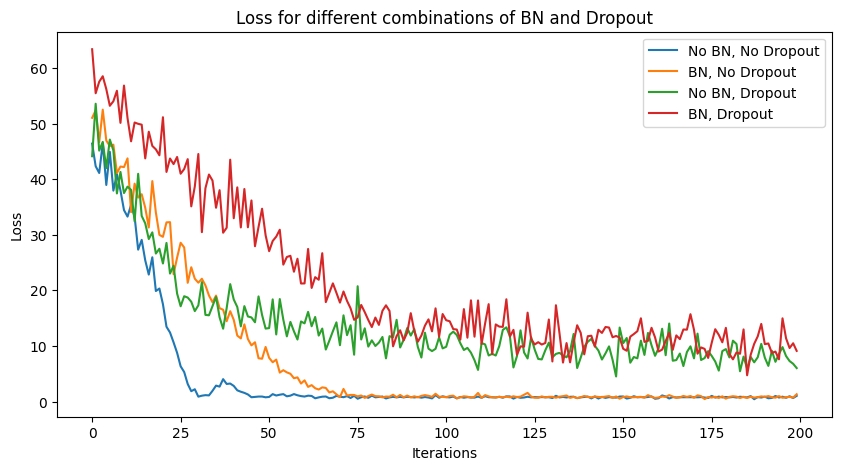

In [139]:
best_batch_size = 64
dataloader = DataLoader(dataset, batch_size=best_batch_size, shuffle=True)
results_combinations = {}

configurations = {
    'No BN, No Dropout': (False, False),
    'BN, No Dropout': (True, False),
    'No BN, Dropout': (False, True),
    'BN, Dropout': (True, True)
}

for name, (batch_norm, dropout) in configurations.items():
    model = create_model(batch_norm=batch_norm, dropout=dropout)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    results_combinations[name] = losses

plt.figure(figsize=(10, 5))
for name, losses in results_combinations.items():
    plt.plot(losses, label=name)
plt.title('Loss for different combinations of BN and Dropout')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

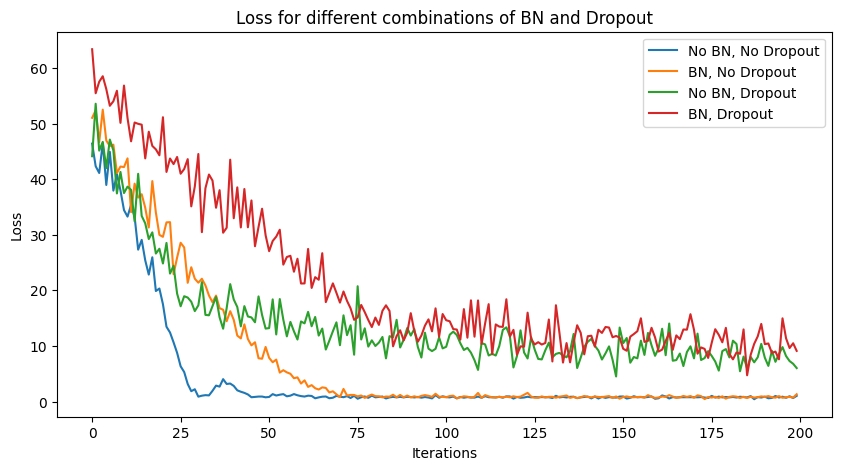

In [140]:
plt.figure(figsize=(10, 5))
for name, losses in results_combinations.items():
    plt.plot(losses, label=name)
plt.title('Loss for different combinations of BN and Dropout')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()